In [2]:
import numpy as np

from qiskit.providers.basicaer import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.opflow.gradients import Gradient
from qiskit_nature.algorithms import AdaptVQE, VQEUCCFactory
from qiskit_nature.circuit.library import HartreeFock, UCC
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, HDF5Driver
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy,
    ParticleNumber,
)
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis
from qiskit_nature.properties.second_quantization.electronic.integrals import (
    OneBodyElectronicIntegrals,
    TwoBodyElectronicIntegrals,)

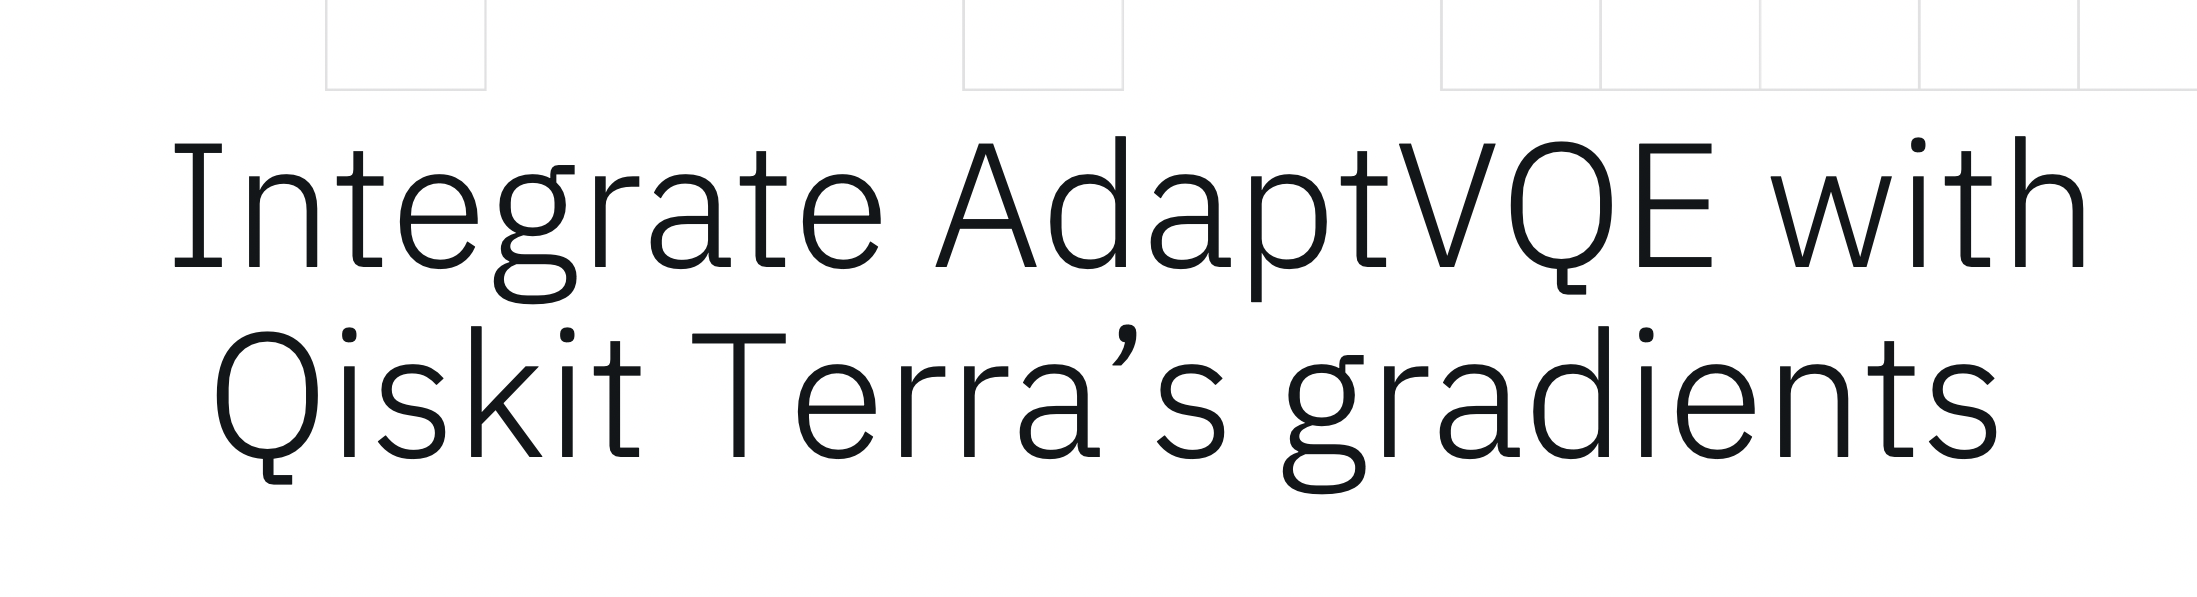
<b>Mentors:</b>
<br><b>Max Rossmannek</b>
<br><b>Dariusz Lasecki</b>
<br>
<br><b>Mentee:</b>
<br><b>Freya Shah</b>

## AdaptVQE:
AdaptVQE is an algorithm which provides the means to find the ground state solution of a Hamiltonian. It is currently a part of qiskit nature and manually calculates the gradients.
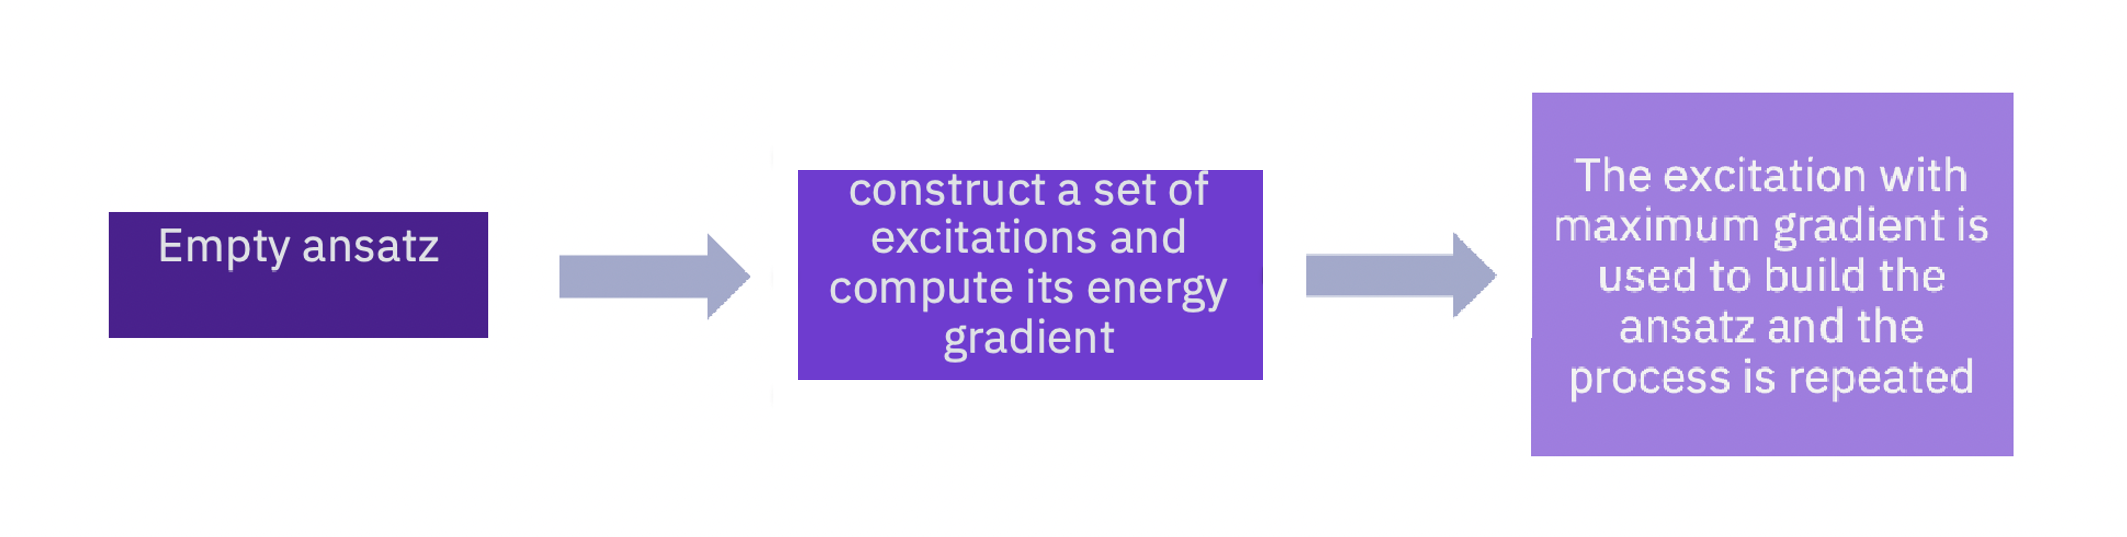

## Gradient Framework
<b>Qiskit Terra has a gradient framework which can calculate the gradients for us!</b>
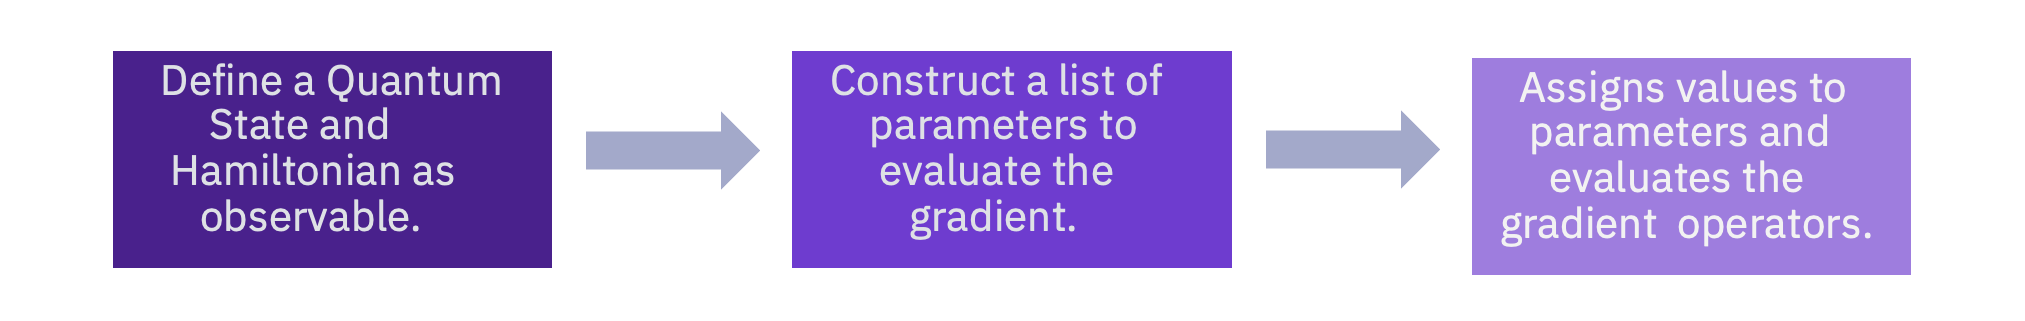

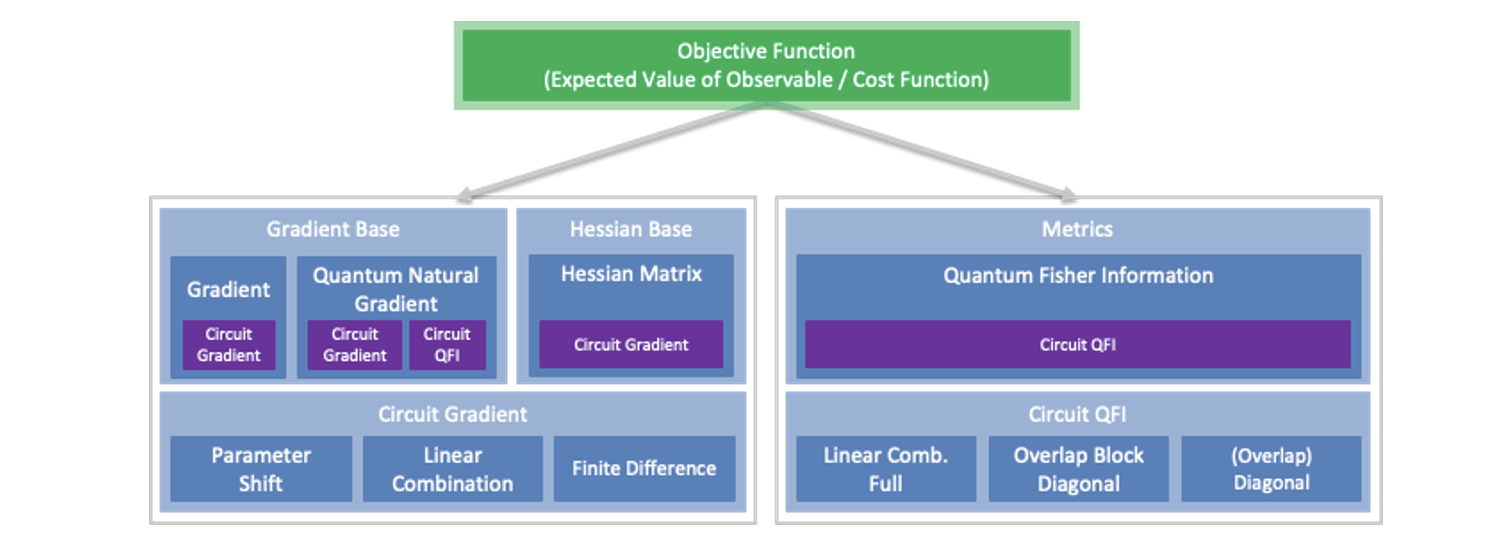

## Gradients :
<b> 1. Parameter Shift Gradient</b>  <font color="red"><b> ("param_shift") </b> </font>
<br> Parameter Shift is analytical method for finding gradients. It calculates the gradients by using eigenvalue 𝑟 dependent shifts to parameters. All standard, parameterized Qiskit gates can be shifted with 𝜋/2.
<br>
 <br> <b>2. Finite Difference Gradient</b> <font color="red"><b>  ("fin_diff")</b> </font> 
<br>Finite difference gradients are numerical estimations rather than analytical values. This implementation employs a central difference approach with 𝜖≪1.

###  Old Code VS New Code 

In [ ]:
#OLD CODE
class AdaptVQE(GroundStateEigensolver):
    """A ground state calculation employing the AdaptVQE algorithm."""
    def __init__(
        self,
        qubit_converter: QubitConverter,
        solver: MinimumEigensolverFactory,
        threshold: float = 1e-5,
        delta: float = 1,
        max_iterations: Optional[int] = None,
    ) -> None:

In [ ]:
#NEW CODE
class AdaptVQE(GroundStateEigensolver):
    """A ground state calculation employing the AdaptVQE algorithm."""
    def __init__(
        self,
        qubit_converter: QubitConverter,
        solver: MinimumEigensolverFactory,
        threshold: float = 1e-5,
        delta: float = 1,  #this is going to be deprecated
        max_iterations: Optional[int] = None,
        gradient: Optional[Gradient] = None,
    ) -> None:

## Old Code

In [ ]:
 def _compute_gradients(
        self,
        theta: List[float],
        vqe: VQE,
    ) -> List[Tuple[float, PauliSumOp]]:
        res = []
        for exc in self._excitation_pool:
            # add next excitation to ansatz
            self._ansatz.operators = self._excitation_list + [exc]
            # set the current ansatz
            vqe.ansatz = self._ansatz
            # evaluate energies
            parameter_sets = theta + [-self._delta] + theta + [self._delta]
            energy_evaluation = vqe.get_energy_evaluation(self._main_operator)
            energy_results = energy_evaluation(np.asarray(parameter_sets))
            # compute gradient
            gradient = (energy_results[0] - energy_results[1]) / (2 * self._delta)
            res.append((np.abs(gradient), exc))

        return res

## New Code

In [ ]:
 def _compute_gradients(
        self,
        theta: List[float],
        vqe: VQE,
    ) -> List[Tuple[float, PauliSumOp]]:
        res=[]
        for exc in self._excitation_pool:
            self._ansatz.operators = self._excitation_list + [exc]
            if self.gradient.grad_method.analytic:
                vqe.ansatz = self._ansatz
            else:
                vqe.ansatz = self._ansatz.decompose()
            param_sets = vqe._ansatz_params 
            op = vqe.construct_expectation(theta, self._main_operator)
            state_grad = self.gradient.convert(operator=op, params=param_sets)
            # Assign the parameters and evaluate the gradient
            value_dict = {param_sets[-1]:0.0}
            state_grad_result = state_grad.assign_parameters(value_dict).eval()
            logger.info("State gradient computed with parameter shift", state_grad_result)
            res.append((np.abs(state_grad_result[-1]), exc))
        return res

## Then :
qubit_converter = QubitConverter(ParityMapper())
<br>solver=VQEUCCFactory(QuantumInstance(BasicAer.get_backend("statevector_simulator")))
<br>calc = <font color="red">AdaptVQE</font>( qubit_converter , solver)

## Now :
 qubit_converter = QubitConverter(ParityMapper())
 <br>solver=VQEUCCFactory(QuantumInstance(BasicAer.get_backend("statevector_simulator")))
 <br><font color="blue">grad = Gradient ( grad_method="fin_diff") </font>
 <br>calc = <font color="red">AdaptVQE</font>( qubit_converter , solver , <font color="red"> gradient=grad</font>)

## Calculating the ground state energy of Hydrogen Atom

<b> Defining the Problem</b>

In [3]:
driver = PySCFDriver(
atom="H .0 .0 .0; H .0 .0 0.735", unit=UnitsType.ANGSTROM, basis="sto3g"
        )
problem = ElectronicStructureProblem(driver)

expected = -1.85727503

qubit_converter = QubitConverter(ParityMapper())
solver=VQEUCCFactory(QuantumInstance(BasicAer.get_backend("statevector_simulator")))

<b>Using Finite Difference Gradient</b>

In [4]:
%%time
#logging.basicConfig(level = logging.DEBUG)
grad=Gradient(grad_method="fin_diff")

calc= AdaptVQE(qubit_converter,solver,gradient=grad)
res = calc.solve(problem)
print("Energy calculated: ",res.electronic_energies[0])
print("Expected energy:   ", expected)

Energy calculated:  -1.85727503014488
Expected energy:    -1.85727503
CPU times: user 16 s, sys: 61.3 ms, total: 16.1 s
Wall time: 16.1 s


### Gradients calculated by AdaptVQE
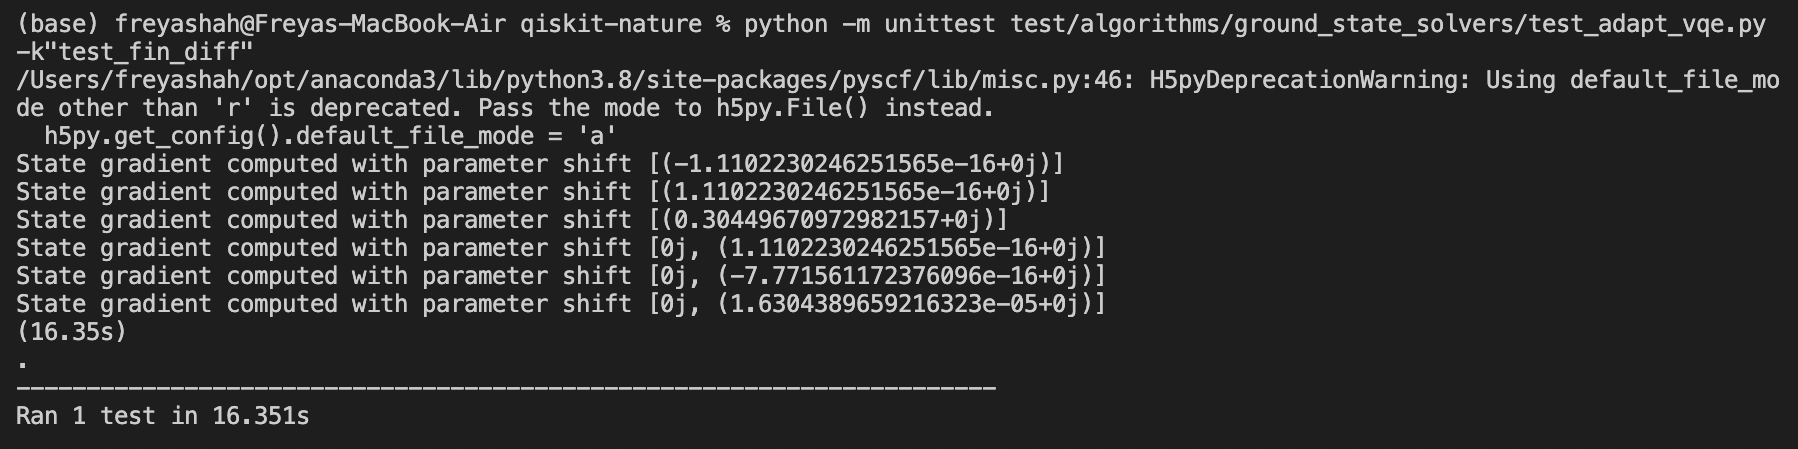

<b>Using Parameter Shift Gradient</b>

In [5]:
%%time
grad=Gradient(grad_method="param_shift")
calc= AdaptVQE(qubit_converter,solver,gradient=grad)
res = calc.solve(problem)
print("Energy calculated: ",res.electronic_energies[0])
print("Expected energy:   ", expected)

Energy calculated:  -1.85727503014488
Expected energy:    -1.85727503
CPU times: user 14 s, sys: 25.7 ms, total: 14.1 s
Wall time: 14.1 s


## Calculating the ground state energy of Lithium Hydride 
<b> Defining the problem </b>

In [3]:
qubit_converter = QubitConverter(ParityMapper())
solver=VQEUCCFactory(QuantumInstance(BasicAer.get_backend("statevector_simulator")))
inter_dist = 1.6
driver1 = PySCFDriver(
    atom="Li .0 .0 .0; H .0 .0 " + str(inter_dist),
    unit=UnitsType.ANGSTROM,
    charge=0,
    spin=0,
    basis="sto3g",
)
transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)
problem1 = ElectronicStructureProblem(driver1, [transformer])
solver = VQEUCCFactory(QuantumInstance(BasicAer.get_backend("statevector_simulator")))

<b> Using Finite Difference Gradient </b>

In [4]:
%%time
grad=Gradient(grad_method="fin_diff")
calc = AdaptVQE(qubit_converter, solver,gradient=grad)
res = calc.solve(problem1)
print("Energy calculated: ",res.electronic_energies[0])

Energy calculated:  (-8.855126477864719+0j)
CPU times: user 11min 7s, sys: 1min 53s, total: 13min
Wall time: 10min 51s


<b>Using Parameter Shift Gradient</b>

In [5]:
%%time
grad=Gradient(grad_method="param_shift")
calc = AdaptVQE(qubit_converter, solver,gradient=grad)
res = calc.solve(problem1)
print("Energy calculated: ",res.electronic_energies[0])

Energy calculated:  (-8.85512647792725+0j)
CPU times: user 9min 58s, sys: 1min 50s, total: 11min 48s
Wall time: 9min 42s


 ## <font color="red"> What if we migrate AdaptVQE to Qiskit Terra?</font>
<b>AdaptVQE uses the UCCSD (Unitary Coupled Cluster Single and Double excitations) ansatz.But UCCSD uses Evolved Operator Ansatz as the base class. Evolved Operator Ansatz is a part of qiskit terra.</b>
